# PopHealth Observatory Exploratory Workbook

This notebook provides a comprehensive, sandbox-style environment for exercising and validating functionality of the `PopHealthObservatory` / `NHANESExplorer` classes.

Sections include: introspection, synthetic data generation, analytical method smoke tests, stratification, trend evaluation, visualization, edge cases, performance profiling, reproducibility, exports, quality assertions, and an end-to-end integration workflow.

> Note: This workbook creates synthetic data for testing; it does not rely solely on live NHANES pulls except in optional sections.

## 1. Environment & Library Imports

Import core scientific, profiling, and inspection libraries plus the project modules.

In [3]:
# Core imports
import os, sys, time, math, json, inspect, gc, tempfile, hashlib, statistics
from pathlib import Path
from datetime import datetime, timedelta
from typing import List, Dict, Any, Callable, Optional

# Data & analysis libs
import numpy as np
import pandas as pd

# Visualization (optional imports guarded)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except Exception as e:
    print(f"Matplotlib/Seaborn not available: {e}")

try:
    import plotly.express as px
except Exception:
    px = None

# Profiling
import cProfile, pstats

# Ensure project root on path
ROOT = Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print(f"Notebook started: {datetime.utcnow().isoformat()}Z")
print(f"Python: {sys.version.split()[0]} | pandas: {pd.__version__} | numpy: {np.__version__}")

Notebook started: 2025-09-18T00:04:26.623497Z
Python: 3.13.7 | pandas: 2.3.2 | numpy: 2.3.3


## 2. Load or Import Observatory Classes
Attempt to import the classes; fall back with a clear message if not available.

In [1]:
try:
    from pophealth_observatory import PopHealthObservatory, NHANESExplorer
    print("Imported PopHealthObservatory & NHANESExplorer successfully.")
except Exception as e:
    PopHealthObservatory = None
    NHANESExplorer = None
    print(f"Import failed: {e}")

print('PopHealthObservatory available:', PopHealthObservatory is not None)
print('NHANESExplorer available:', NHANESExplorer is not None)

Imported PopHealthObservatory & NHANESExplorer successfully.
PopHealthObservatory available: True
NHANESExplorer available: True


In [2]:
from pophealth_observatory.observatory import NHANESExplorer
exp = NHANESExplorer()
merged = exp.create_merged_dataset('2017-2018')
print(merged.head())


Creating merged dataset for 2017-2018...
Trying demographics URL: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DEMO_J.xpt
✓ Success loading demographics from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DEMO_J.xpt
Trying BMX URL: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/BMX_J.xpt
✓ Success loading BMX from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/BMX_J.xpt
Trying BPX URL: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/BPX_J.xpt
✓ Success loading BPX from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/BPX_J.xpt
Merged dataset created with 9254 participants and 23 variables
   participant_id  gender  age_years  race_ethnicity  education  \
0         93703.0     2.0        2.0             6.0        NaN   
1         93704.0     1.0        2.0             3.0        NaN   
2         93705.0     2.0       66.0             4.0        2.0   
3         93706.0     1.0       18.0             6.0    

Creating merged dataset for 2017-2018...
Trying demographics URL: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DEMO_J.xpt
✓ Success loading demographics from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/DEMO_J.xpt
Trying BMX URL: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/BMX_J.xpt
✓ Success loading BMX from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/BMX_J.xpt
Trying BPX URL: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/BPX_J.xpt
✓ Success loading BPX from: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2017/DataFiles/BPX_J.xpt
Merged dataset created with 9254 participants and 23 variables
PopHealth Observatory Summary Report
Total Participants: 9,254
Total Variables: 23

Age Distribution:
  Mean age: 34.3 years
  Age range: 0 - 80 years

Gender Distribution:
  Female: 4,697 (50.8%)
  Male: 4,557 (49.2%)

Race/Ethnicity Distribution:
  Non-Hispanic White: 3,150 (34.0%)
  Non-Hispanic Black: 2,115 (22.9%)
  M

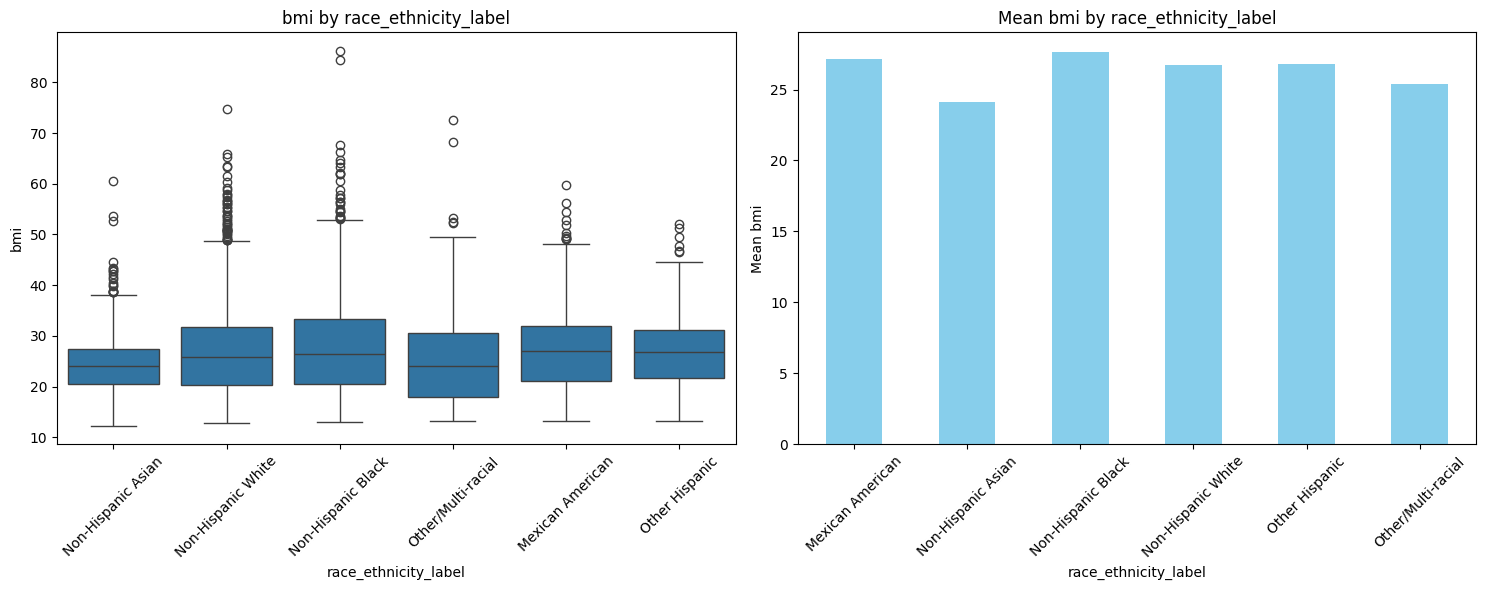

In [4]:
from pophealth_observatory import NHANESExplorer

# Initialize the explorer (NHANES-focused implementation)
explorer = NHANESExplorer()

# Download and merge demographics, body measures, and blood pressure data
data = explorer.create_merged_dataset('2017-2018')

# Generate a summary report
print(explorer.generate_summary_report(data))

# Analyze BMI by race/ethnicity
bmi_by_race = explorer.analyze_by_demographics(data, 'bmi', 'race_ethnicity_label')
print(bmi_by_race)

# Create visualization
explorer.create_demographic_visualization(data, 'bmi', 'race_ethnicity_label')

In [8]:

## Generate Manifest (XPT only, 2010-2022)
manifest = exp.get_detailed_component_manifest(
    as_dataframe=True,
    year_range=("2010","2022"),
    file_types=["XPT"],
)
print(manifest['summary_counts'])

{'Demographics': {'XPT': 7}, 'Examination': {'XPT': 105}, 'Laboratory': {'XPT': 440}, 'Dietary': {'XPT': 79}, 'Questionnaire': {'XPT': 286}}


In [9]:
# US Federal Debt-to-GDP Ratio (Past 50 Years) – FRED series GFDEGDQ188S
import pandas as pd
import plotly.express as px
from datetime import datetime

FRED_URL = "https://fred.stlouisfed.org/series/GFDEGDQ188S/downloaddata/GFDEGDQ188S.csv"

try:
    df = pd.read_csv(FRED_URL)
    df.columns = [c.strip() for c in df.columns]
    df["DATE"] = pd.to_datetime(df["DATE"])
    df = df[df["DATE"] >= (pd.Timestamp.now() - pd.DateOffset(years=50))]
    df = df[df["VALUE"] != "."]  # remove missing
    df["value"] = pd.to_numeric(df["VALUE"])
except Exception as e:
    print(f"Could not download data from FRED: {e}")
    # Create sample data for demonstration
    years = pd.date_range(end=pd.Timestamp.now(), periods=50, freq="Y")
    import numpy as np
    np.random.seed(0)
    values = np.linspace(30, 120, 50) + np.random.normal(0, 5, 50)
    df = pd.DataFrame({"DATE": years, "value": values})

fig = px.line(
    df,
    x="DATE",
    y="value",
    title="US Federal Debt-to-GDP Ratio (Last 50 Years)",
    labels={"DATE": "Date", "value": "Debt / GDP (%)"},
)

fig.update_traces(mode="lines", line=dict(color="#1f77b4", width=2))
fig.update_layout(
    yaxis=dict(ticksuffix="%", rangemode="tozero"),
    hovermode="x unified",
    template="plotly_white",
)

fig.show()

Could not download data from FRED: <urlopen error [Errno 11001] getaddrinfo failed>


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed